In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
df = pd.read_csv('data/Delhi_v2.csv')

In [5]:
df.head(3)

,Unnamed: 0,price,Address,area,latitude,longitude,Bedrooms,Bathrooms,Balcony,Status,neworold,parking,Furnished_status,Lift,Landmarks,type_of_building,desc,Price_sqft
0,0,5600000.0,"Noida Extension, Noida, Delhi NCR",1350.0,28.608850,77.460560,3.0,3.0,NaN,Under Construction,New Property,NaN,NaN,2.0,NaN,Flat,\n\n\n Welcome ...,4148.148148
1,1,8800000.0,"Sector 79, Gurgaon, Delhi NCR",1490.0,28.374236,76.952416,3.0,3.0,NaN,Ready to Move,New Property,NaN,Semi-Furnished,2.0,NaN,Flat,\n\n\n Mapsko M...,5906.040268
2,2,16500000.0,"Vaishali, Ghaziabad, Delhi NCR",2385.0,28.645769,77.385110,4.0,5.0,NaN,Ready to Move,New Property,1.0,Unfurnished,NaN,NaN,Flat,\n\n\n This pro...,6918.238994


In [14]:
df['price'].sum,df.shape,df.info(),df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7738 entries, 0 to 7737
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7738 non-null   int64  
 1   price             7738 non-null   float64
 2   Address           7738 non-null   object 
 3   area              7738 non-null   float64
 4   latitude          7738 non-null   float64
 5   longitude         7738 non-null   float64
 6   Bedrooms          7738 non-null   float64
 7   Bathrooms         7738 non-null   float64
 8   Balcony           5166 non-null   float64
 9   Status            7164 non-null   object 
 10  neworold          7738 non-null   object 
 11  parking           2612 non-null   float64
 12  Furnished_status  4124 non-null   object 
 13  Lift              1733 non-null   float64
 14  Landmarks         2759 non-null   object 
 15  type_of_building  7738 non-null   object 
 16  desc              7738 non-null   object 


(<bound method Series.sum of 0        5600000.0
 1        8800000.0
 2       16500000.0
 3        3810000.0
 4        6200000.0
            ...    
 7733     7900000.0
 7734     4510000.0
 7735     7000000.0
 7736     6500000.0
 7737     6500000.0
 Name: price, Length: 7738, dtype: float64>,
 (7738, 18),
 None,
 Unnamed: 0             0
 price                  0
 Address                0
 area                   0
 latitude               0
 longitude              0
 Bedrooms               0
 Bathrooms              0
 Balcony             2572
 Status               574
 neworold               0
 parking             5126
 Furnished_status    3614
 Lift                6005
 Landmarks           4979
 type_of_building       0
 desc                   0
 Price_sqft             0
 dtype: int64)

In [15]:
df = df.drop(columns=['Unnamed: 0', 'Landmarks'], errors='ignore')


In [17]:
y = df['price']  
X = df.drop(columns=['price'])


In [18]:
X = X.dropna(axis=1, how='all')


In [19]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()


In [20]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [22]:
model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])


In [23]:
model_pipeline.fit(X_train, y_train)


,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [24]:
y_pred = model_pipeline.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 1013311.8898558063
MSE: 4128668080563.6006
RMSE: 2031912.4195111364
R2 Score: 0.930357438240838


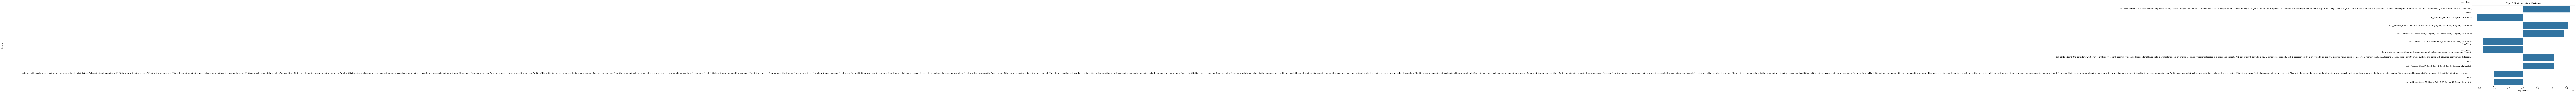

In [29]:
feature_names = model_pipeline.named_steps['preprocessing'].get_feature_names_out()
coefs = model_pipeline.named_steps['regressor'].coef_

importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefs
}).sort_values(by='Importance', key=abs, ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=importance.head(10))
plt.title('Top 10 Most Important Features')
plt.subplots_adjust(left=0.3, right=0.95) 
plt.show()
